# sklearn Machine Learning Examples

This notebook demonstrates classification, regression, dimensionality reduction, and clustering using sklearn.


## 1. Classification Example


In [ ]:
# !pip install scikit-learn numpy matplotlib seaborn

# Create the Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold  # Correct import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 1.2 Feature Engineering


In [2]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

df = df.select_dtypes(include=[np.number])

selector = VarianceThreshold(threshold=0.0)
X_temp = df.drop('Survived', axis=1)
selector.fit(X_temp)
selected_features = X_temp.columns[selector.get_support()]
df = df[list(selected_features) + ['Survived']]

correlation_matrix = df.drop('Survived', axis=1).corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
df = df.drop(columns=high_corr_features)

X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 1.3 Logistic Regression


In [8]:
from sklearn.impute import SimpleImputer

# Create the imputer (fills NaNs with the average of the column)
imputer = SimpleImputer(strategy='mean')

# Fit on training data, transform both
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# NOW you can run your scaler and model

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]


### 1.4 Random Forest


In [10]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]


### 1.5 Model Comparison


In [11]:
metrics = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred)
    ],
    'Precision': [
        precision_score(y_test, lr_pred),
        precision_score(y_test, rf_pred)
    ],
    'Recall': [
        recall_score(y_test, lr_pred),
        recall_score(y_test, rf_pred)
    ],
    'F1-Score': [
        f1_score(y_test, lr_pred),
        f1_score(y_test, rf_pred)
    ],
    'AUC-ROC': [
        roc_auc_score(y_test, lr_pred_proba),
        roc_auc_score(y_test, rf_pred_proba)
    ]
}

comparison_df = pd.DataFrame(metrics)
print(comparison_df)


                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0  Logistic Regression  0.731844   0.770833  0.500000  0.606557  0.783655
1        Random Forest  0.720670   0.681818  0.608108  0.642857  0.811583


## 2. Regression Example


### 2.1 Data Loading and Preparation


In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import VarianceThreshold  

house_df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv')
house_df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2.2 Feature Engineering


In [13]:
house_df = pd.get_dummies(house_df, columns=['ocean_proximity'], drop_first=True)

house_df = house_df.select_dtypes(include=[np.number])

selector_house = VarianceThreshold(threshold=0.0)
X_temp_house = house_df.drop('median_house_value', axis=1)
selector_house.fit(X_temp_house)
selected_features_house = X_temp_house.columns[selector_house.get_support()]
house_df = house_df[list(selected_features_house) + ['median_house_value']]

correlation_matrix = house_df.drop('median_house_value', axis=1).corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
house_df = house_df.drop(columns=high_corr_features)

X_house = house_df.drop('median_house_value', axis=1)
y_house = house_df['median_house_value']
X_train_house, X_test_house, y_train_house, y_test_house = train_test_split(
    X_house, y_house, test_size=0.2, random_state=42
)


### 2.3 KNN Regression


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

knn_pipeline.fit(X_train_house, y_train_house)
knn_pred = knn_pipeline.predict(X_test_house)

### 2.4 Linear Regression


In [15]:
X_train_lr = X_train_house.fillna(X_train_house.median())
X_test_lr = X_test_house.fillna(X_train_house.median())

scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
X_test_lr_scaled = scaler_lr.transform(X_test_lr)

correlation_matrix_lr = pd.DataFrame(X_train_lr_scaled).corr().abs()
upper_triangle_lr = correlation_matrix_lr.where(
    np.triu(np.ones(correlation_matrix_lr.shape), k=1).astype(bool)
)
high_corr_features_lr = [column for column in upper_triangle_lr.columns if any(upper_triangle_lr[column] > 0.95)]
X_train_lr_scaled = pd.DataFrame(X_train_lr_scaled).drop(columns=high_corr_features_lr).values
X_test_lr_scaled = pd.DataFrame(X_test_lr_scaled).drop(columns=high_corr_features_lr).values

lr_reg_model = LinearRegression()
lr_reg_model.fit(X_train_lr_scaled, y_train_house)
lr_reg_pred = lr_reg_model.predict(X_test_lr_scaled)


### 2.5 Model Comparison


In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

regression_metrics = {
    'Model': ['KNN Regression', 'Linear Regression'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_house, knn_pred)),
        np.sqrt(mean_squared_error(y_test_house, lr_reg_pred))
    ],
    'MAE': [
        mean_absolute_error(y_test_house, knn_pred),
        mean_absolute_error(y_test_house, lr_reg_pred)
    ],
    'R2': [
        r2_score(y_test_house, knn_pred),
        r2_score(y_test_house, lr_reg_pred)
    ],
    'MAPE': [
        mean_absolute_percentage_error(y_test_house, knn_pred),
        mean_absolute_percentage_error(y_test_house, lr_reg_pred)
    ]
}

regression_comparison_df = pd.DataFrame(regression_metrics)
print(regression_comparison_df)


               Model          RMSE           MAE        R2       MAPE
0     KNN Regression  63120.261196  42799.195349  0.695960  24.076814
1  Linear Regression  71878.817762  52166.426001  0.605729  31.200131


### Discussion: are these a good models?

## 3. PCA with Normalization


### 3.1 Data Preparation


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_df = house_df.copy()
X_pca = pca_df.drop('median_house_value', axis=1)
X_pca = X_pca.fillna(X_pca.median())


### 3.2 Normalization and PCA


In [18]:
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

pca = PCA(n_components=0.95)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

print(f"Original features: {X_pca_scaled.shape[1]}")
print(f"PCA components (95% variance): {X_pca_transformed.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")


Original features: 7
PCA components (95% variance): 4
Explained variance ratio: 0.9630


### 3.3 Variance Explained Visualization


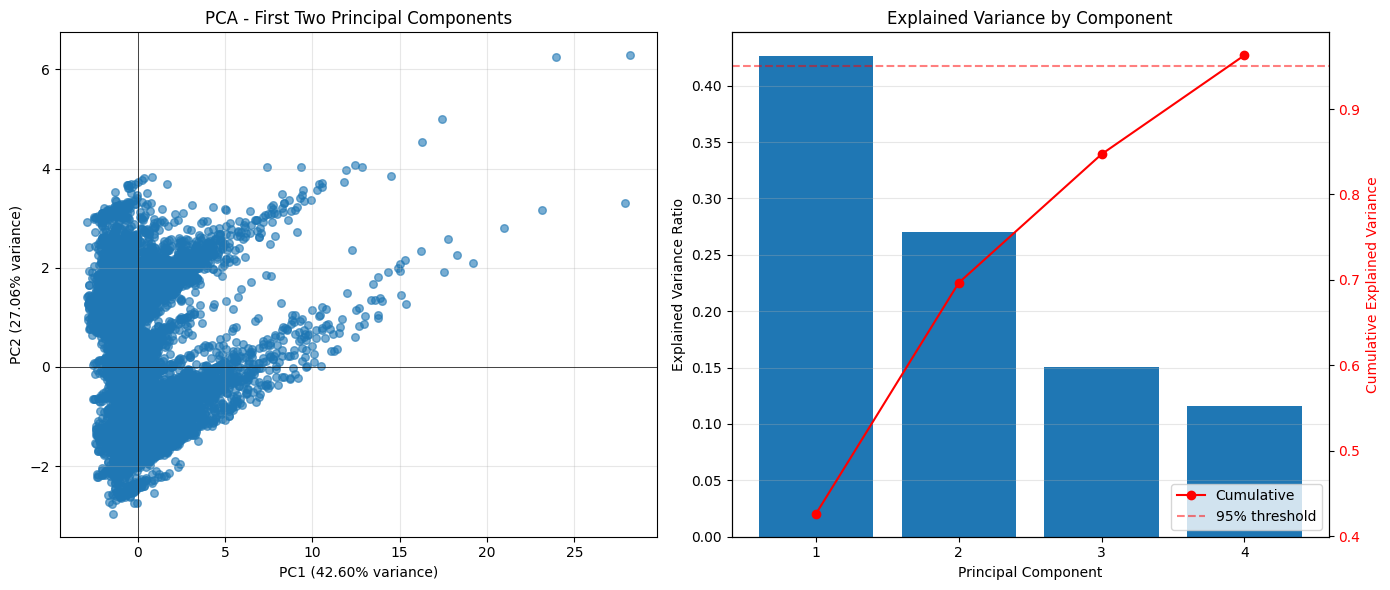

Variance explained by PC1: 0.4260
Variance explained by PC2: 0.2706
Total variance (first 2 components): 0.6966


In [19]:
import matplotlib.pyplot as plt

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_pca_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PCA - First Two Principal Components')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5)

n_components_to_show = min(10, len(pca.explained_variance_ratio_))
axes[1].bar(range(1, n_components_to_show + 1), 
            pca.explained_variance_ratio_[:n_components_to_show])
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('Explained Variance by Component')
axes[1].set_xticks(range(1, n_components_to_show + 1))
axes[1].grid(True, alpha=0.3, axis='y')

cumsum_var = np.cumsum(pca.explained_variance_ratio_[:n_components_to_show])
ax2 = axes[1].twinx()
ax2.plot(range(1, n_components_to_show + 1), cumsum_var, 'r-', marker='o', label='Cumulative')
ax2.set_ylabel('Cumulative Explained Variance', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% threshold')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Variance explained by PC1: {pca_2d.explained_variance_ratio_[0]:.4f}")
print(f"Variance explained by PC2: {pca_2d.explained_variance_ratio_[1]:.4f}")
print(f"Total variance (first 2 components): {pca_2d.explained_variance_ratio_.sum():.4f}")

## 4. K-Means Clustering with Elbow Method


### 4.1 Data Preparation


In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold  

kmeans_df = house_df.copy()
X_kmeans = kmeans_df.drop('median_house_value', axis=1)
X_kmeans = X_kmeans.fillna(X_kmeans.median())


### 4.2 Feature Engineering


In [21]:
X_kmeans = X_kmeans.select_dtypes(include=[np.number])

selector_km = VarianceThreshold(threshold=0.0)
selector_km.fit(X_kmeans)
selected_features_km = X_kmeans.columns[selector_km.get_support()]
X_kmeans = X_kmeans[selected_features_km]

correlation_matrix_km = X_kmeans.corr().abs()
upper_triangle_km = correlation_matrix_km.where(
    np.triu(np.ones(correlation_matrix_km.shape), k=1).astype(bool)
)
high_corr_features_km = [column for column in upper_triangle_km.columns if any(upper_triangle_km[column] > 0.95)]
X_kmeans = X_kmeans.drop(columns=high_corr_features_km)

scaler_km = StandardScaler()
transformer_km = PowerTransformer(method='yeo-johnson')

X_kmeans_scaled = scaler_km.fit_transform(X_kmeans)
X_kmeans_transformed = transformer_km.fit_transform(X_kmeans_scaled)


### 4.3 Elbow Method


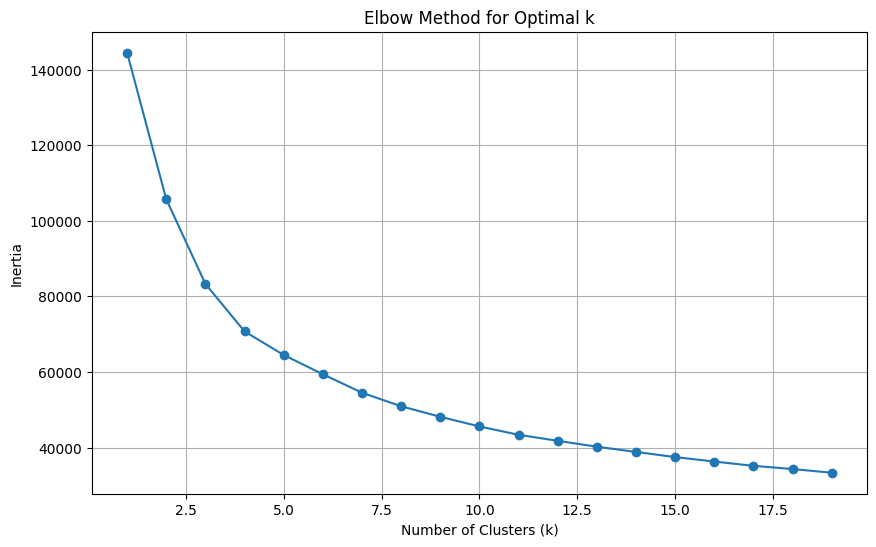

In [22]:
inertias = []
K_range = range(1, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kmeans_transformed)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


### 4.4 Final K-Means Model


In [23]:
optimal_k = 2
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = final_kmeans.fit_predict(X_kmeans_transformed)

silhouette_avg = silhouette_score(X_kmeans_transformed, clusters)
print(f"Optimal k: {optimal_k}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Cluster sizes: {np.bincount(clusters)}")


Optimal k: 2
Silhouette Score: 0.2308
Cluster sizes: [ 9717 10923]


### Visualizations

In [24]:
X_kmeans['Cluster'] = clusters

cluster_summary = X_kmeans.groupby('Cluster').agg(['mean', 'std', 'count'])

print("=" * 80)
print("CLUSTER CHARACTERISTICS - Mean Values")
print("=" * 80)
for cluster_id in range(optimal_k):
    print(f"\n--- Cluster {cluster_id} (n={np.sum(clusters == cluster_id)}) ---")
    cluster_means = X_kmeans[X_kmeans['Cluster'] == cluster_id].drop('Cluster', axis=1).mean()
    print(cluster_means.sort_values(ascending=False))


CLUSTER CHARACTERISTICS - Mean Values

--- Cluster 0 (n=9717) ---
total_rooms           3940.323248
population            2102.166409
total_bedrooms         796.717094
latitude                35.229194
housing_median_age      23.118143
median_income            4.058788
longitude             -119.188280
dtype: float64

--- Cluster 1 (n=10923) ---
total_rooms           1475.238396
population             823.499863
total_bedrooms         305.653575
latitude                35.990070
housing_median_age      33.551222
median_income            3.703324
longitude             -119.909016
dtype: float64


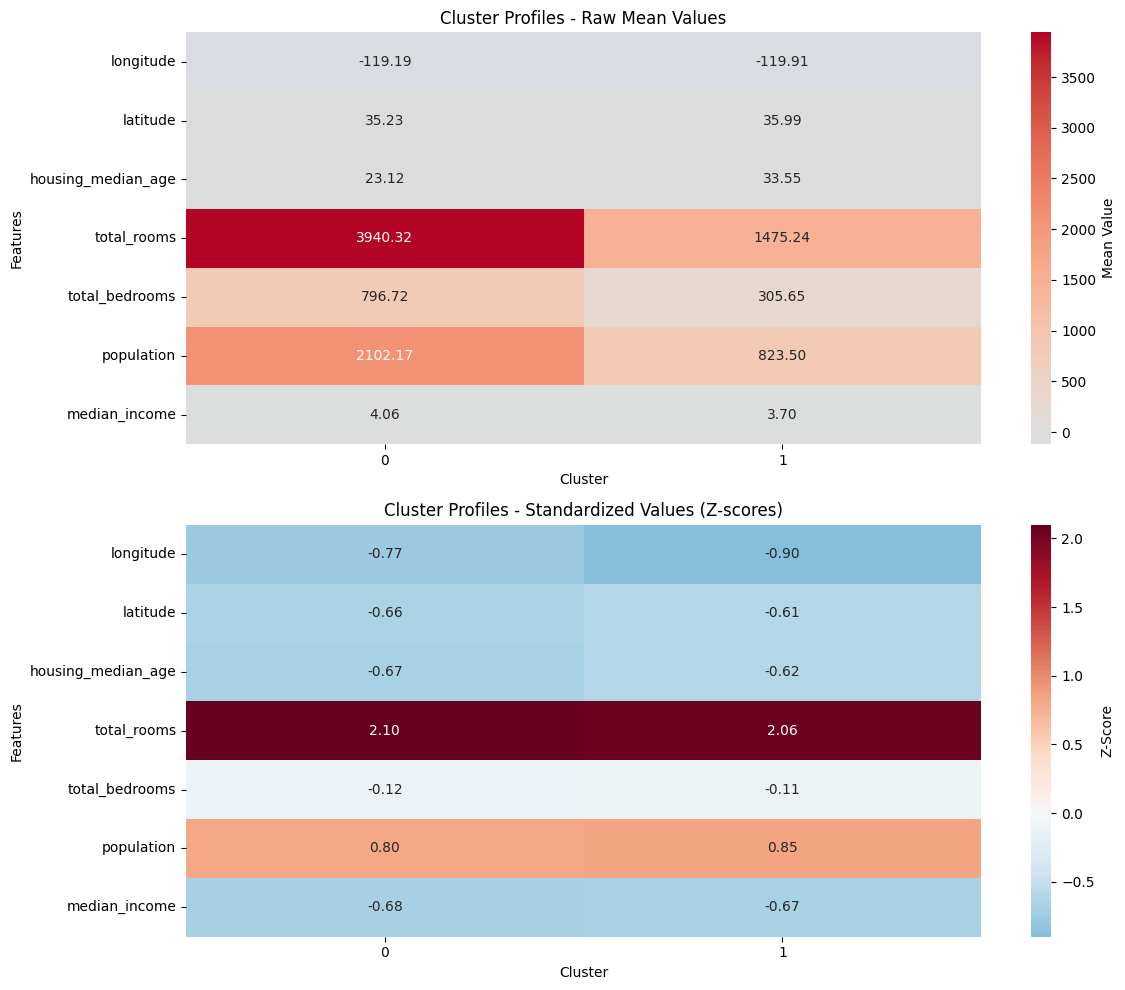

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

cluster_profiles = X_kmeans.groupby('Cluster').mean()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_profiles_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profiles.T).T,
    index=cluster_profiles.index,
    columns=cluster_profiles.columns
)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], cbar_kws={'label': 'Mean Value'})
axes[0].set_title('Cluster Profiles - Raw Mean Values')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Features')

# Heatmap 2: Standardized values (z-scores)
sns.heatmap(cluster_profiles_scaled.T, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=axes[1], cbar_kws={'label': 'Z-Score'})
axes[1].set_title('Cluster Profiles - Standardized Values (Z-scores)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

In [26]:
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE FOR CLUSTERING")
print("=" * 80)

feature_importance = cluster_profiles.var(axis=0).sort_values(ascending=False)
print("\nFeatures with highest variance across clusters (most discriminative):")
print(feature_importance)

print("\n" + "=" * 80)
print("DETAILED CLUSTER COMPARISON")
print("=" * 80)
comparison_df = pd.DataFrame()
for i in range(optimal_k):
    comparison_df[f'Cluster_{i}'] = X_kmeans[X_kmeans['Cluster'] == i].drop('Cluster', axis=1).mean()

comparison_df = comparison_df.T
print(comparison_df.round(2))

print("\n" + "=" * 80)
print("DISTINCTIVE FEATURES PER CLUSTER")
print("=" * 80)
for cluster_id in range(optimal_k):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_data = cluster_profiles_scaled.loc[cluster_id].sort_values(ascending=False)
    high_features = cluster_data[cluster_data > 1.5].index.tolist()
    low_features = cluster_data[cluster_data < -1.5].index.tolist()
    
    if high_features:
        print(f"Notably HIGH: {', '.join(high_features)}")
    if low_features:
        print(f"Notably LOW: {', '.join(low_features)}")
    if not high_features and not low_features:
        print("No extremely distinctive features (moderate values)")



FEATURE IMPORTANCE FOR CLUSTERING

Features with highest variance across clusters (most discriminative):
total_rooms           3.038322e+06
population            8.174941e+05
total_bedrooms        1.205717e+05
housing_median_age    5.442457e+01
latitude              2.894664e-01
longitude             2.597298e-01
median_income         6.317742e-02
dtype: float64

DETAILED CLUSTER COMPARISON
           longitude  latitude  housing_median_age  total_rooms  \
Cluster_0    -119.19     35.23               23.12      3940.32   
Cluster_1    -119.91     35.99               33.55      1475.24   

           total_bedrooms  population  median_income  
Cluster_0          796.72     2102.17           4.06  
Cluster_1          305.65      823.50           3.70  

DISTINCTIVE FEATURES PER CLUSTER

--- Cluster 0 ---
Notably HIGH: total_rooms

--- Cluster 1 ---
Notably HIGH: total_rooms


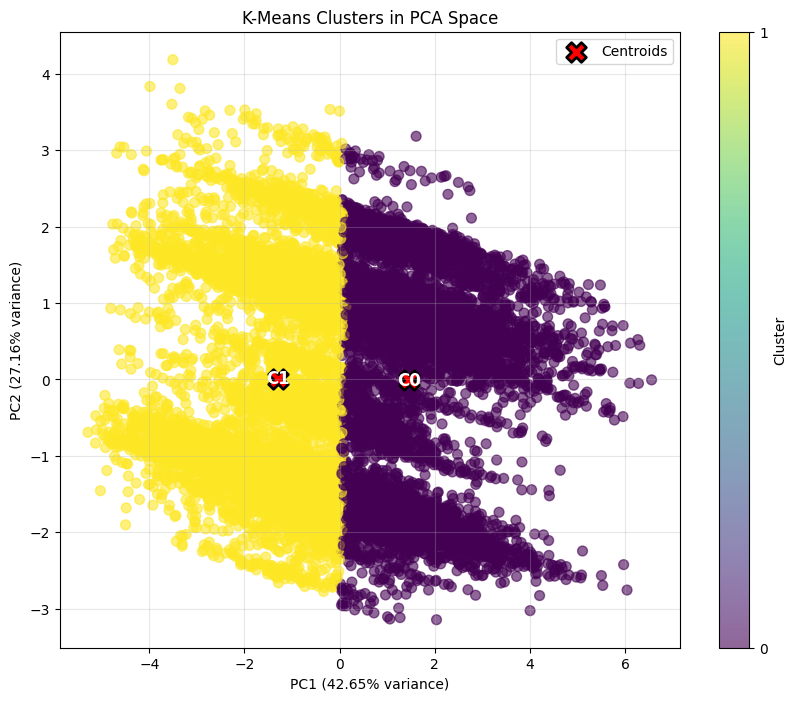

In [27]:
from sklearn.decomposition import PCA

pca_viz = PCA(n_components=2)
X_pca_viz = pca_viz.fit_transform(X_kmeans_transformed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], 
                     c=clusters, cmap='viridis', alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.2%} variance)')
plt.title('K-Means Clusters in PCA Space')
plt.colorbar(scatter, label='Cluster', ticks=range(optimal_k))

# Add cluster centers
centers_pca = pca_viz.transform(final_kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='X', s=200, edgecolors='black', linewidth=2,
           label='Centroids')

# Add cluster labels
for i, (x, y) in enumerate(centers_pca):
    plt.annotate(f'C{i}', (x, y), fontsize=12, fontweight='bold',
                ha='center', va='center', color='white')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Clean up - remove the cluster column if you want to keep original data intact
X_kmeans = X_kmeans.drop('Cluster', axis=1)